## Classifying our variables

Our current variables can be classified as either categorical or numerical data, as shown:

| Categorical            | Numerical                | Mixed                        |
|------------------------|--------------------------|------------------------------|
| `domain_in_ip`         | `length_url`             | `time_domain_activation`     |
| `url_shortened`        |                          | `time_domain_expiration`     |
| `tls_ssl_certificate`  |                          | `qty_at_url`                 |
| `url_google_index`     |                          | `qty_dot_domain`             |
| `domain_google_index`  |                          | `qty_hyphen_domain`          |
| `phishing`             |                          |                              |

<br>

The reason `time_domain_activation`, `time_domain_expiration`, `qty_at_url`, `qty_dot_domain` and `qty_hyphen_domain` are mixed is due to a two-part process:
1. Determine if the attribute exists and is non-null (categorical). 
2. If it does, we then analyse the numerical values to assess for potential phishing activity.

---

## Analysing Categorical Data

For analysing the catgorical variables against the `phishing` variable (which is also a categorical variable), we will use a Contingency Table (this method is also known as Cross Tabulation). This table displays how often different combinations of the categorical variables occur.

We will also utilise the following statistics in conjunction with our Contingency Table:

- **Chi-Square Statistic**: This statistic measures how much our observed data differs from what we would expect if there were truly no relationship between the variables.
- **P-value**: The statistic helps us determine the significance of our results. It represents the probability of observing results as extreme, or more extreme, than our current data if there were truly no relationship between the variables.

In [89]:
# Open the datasets and import libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score


url_information = pd.read_csv('../datasets/sampled_url_information.csv')

In [17]:
# Create the contingency tables
ip_vs_phishing = pd.crosstab(url_information['domain_in_ip'], url_information['phishing'])
shortened_vs_phishing = pd.crosstab(url_information['url_shortened'], url_information['phishing'])
certificate_vs_phishing = pd.crosstab(url_information['tls_ssl_certificate'], url_information['phishing'])
urlgoogle_vs_phishing = pd.crosstab(url_information['url_google_index'], url_information['phishing'])
domaingoogle_vs_phishing = pd.crosstab(url_information['domain_google_index'], url_information['phishing'])

In [35]:

def displayContingencyTable(contingency_table):
    # Performing Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi-square Statistic: {chi2}, p-value: {p}")

    # Interpretation of the result
    if p < 0.05:
        print("There is a significant association between the two variables.")
    else:
        print("There is no significant association between the two variables.")

    # Plotting the heatmap
    x_label = 'phishing'
    y_label = contingency_table.index.name
    title = f'Heatmap of {x_label} vs. {y_label}'

    plt.figure(figsize=(6, 4)) 
    sb.heatmap(contingency_table, annot=True, fmt='g')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

Chi-square Statistic: 20.401182410872465, p-value: 6.279098696288341e-06
There is a significant association between the two variables.


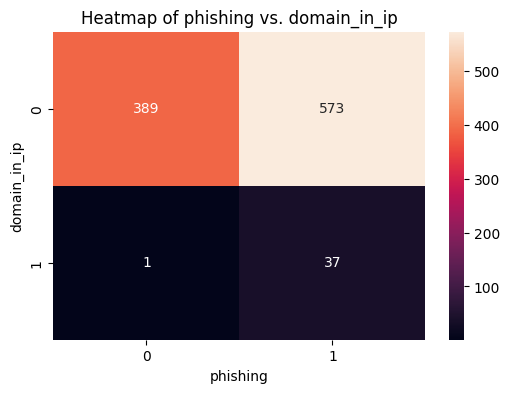

Chi-square Statistic: 13.487153215636827, p-value: 0.00024020234060995253
There is a significant association between the two variables.


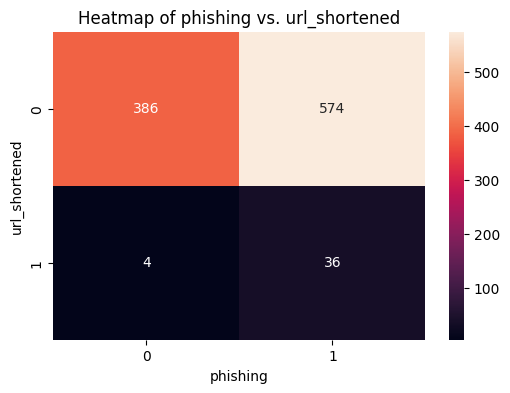

Chi-square Statistic: 4.927724573246753, p-value: 0.026429096063403993
There is a significant association between the two variables.


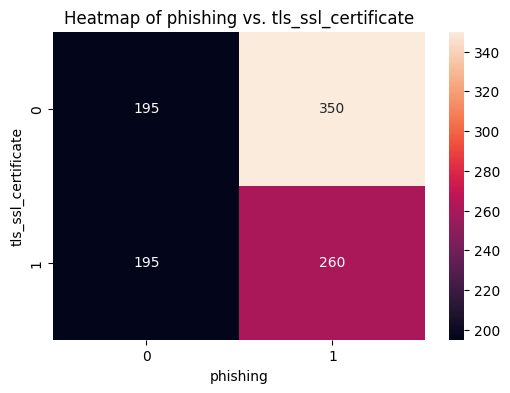

Chi-square Statistic: 69.5370203566925, p-value: 7.947451486666208e-16
There is a significant association between the two variables.


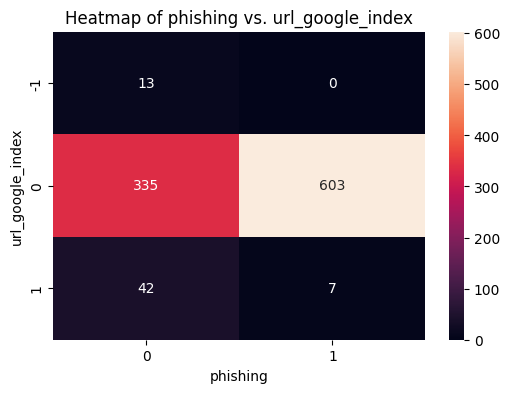

Chi-square Statistic: 46.04948471539767, p-value: 1.0011091869349528e-10
There is a significant association between the two variables.


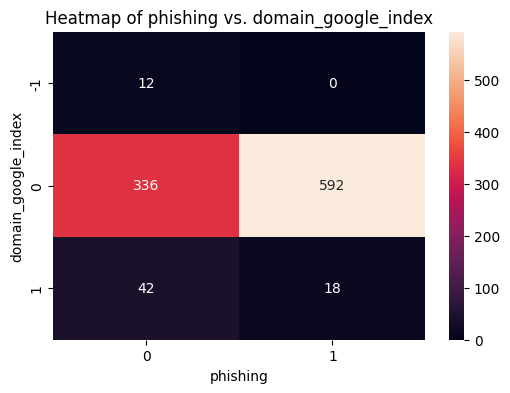

In [36]:
contingency_tables = [
    ip_vs_phishing,
    shortened_vs_phishing,
    certificate_vs_phishing,
    urlgoogle_vs_phishing,
    domaingoogle_vs_phishing
]

for table in contingency_tables:
    displayContingencyTable(table)

---

## Analysing Numerical Data

For analysing the numerical variables against the `phishing` variable, we will follow a two-stage approach:

1. **Basic Statistical Analysis**: Analysing basic summary statistics offers insights into how the data is distributed.
2. **Visualisation:** Box plots will illustrate the distribution of each numerical variable for both phishing and non-phishing websites, revealing potential differences.
3. **Modeling:** We will use Decision Trees for binary classification, as it can clarify the decision rules distinguishing phishing sites.


In [92]:
# Display the basic summary statistics, observe that mean and median URL Length of phishing websites are much higher than 
summary_statistics = url_information.groupby('phishing')['length_url'].describe()
print(summary_statistics)

          count       mean        std  min    25%   50%    75%    max
phishing                                                             
0         390.0  20.379487  10.879314  6.0  15.00  18.0   23.0  120.0
1         610.0  91.301639  81.612188  8.0  40.25  67.0  104.0  677.0


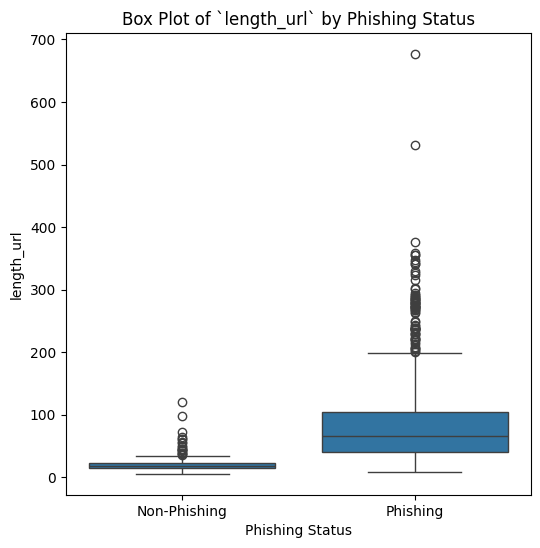

In [93]:
# Visualise the distribution using a box plot

def displayBoxPlot(numerical_data):
    plt.figure(figsize=(6, 6))
    sb.boxplot(x='phishing', y=numerical_data, data=url_information)
    plt.title(f'Box Plot of `{numerical_data}` by Phishing Status')
    plt.xlabel('Phishing Status')
    plt.ylabel(numerical_data)
    plt.xticks([0, 1], ['Non-Phishing', 'Phishing'])
    plt.show()

displayBoxPlot('length_url')

In [94]:
# Function to evaluate and print the Decision Tree's performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Make predictions on the train and test data, using the model DecisionTreeClassifier model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Performing the calculations
    cm_train = confusion_matrix(y_train, y_train_pred) # Confusion Matrices
    cm_test = confusion_matrix(y_test, y_test_pred)

    accuracy_train = accuracy_score(y_train, y_train_pred) # Classification Accuracy
    accuracy_test = accuracy_score(y_test, y_test_pred)

    tpr_train = recall_score(y_train, y_train_pred, pos_label=1)  # True Positive Rate
    tpr_test = recall_score(y_test, y_test_pred, pos_label=1)

    fpr_train = 1 - recall_score(y_train, y_train_pred, pos_label=0)  # False Positive Rate, which is basically 1-TPR
    fpr_test = 1 - recall_score(y_test, y_test_pred, pos_label=0)
    
    plt.subplot(1, 2, 1)  # Train heatmap
    sb.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix (Train)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Non-Phishing', 'Phishing'])
    plt.yticks([0.5, 1.5], ['Non-Phishing', 'Phishing'])

    plt.subplot(1, 2, 2)  # Test heatmap
    sb.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix (Test)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Non-Phishing', 'Phishing'])
    plt.yticks([0.5, 1.5], ['Non-Phishing', 'Phishing'])

    plt.tight_layout()
    plt.show()
    
    print(f"Accuracy (Train): {accuracy_train:.4f}, TPR (Train): {tpr_train:.4f}, FPR (Train): {fpr_train:.4f}")
    print(f"Accuracy (Test): {accuracy_test:.4f}, TPR (Test): {tpr_test:.4f}, FPR (Test): {fpr_test:.4f}")


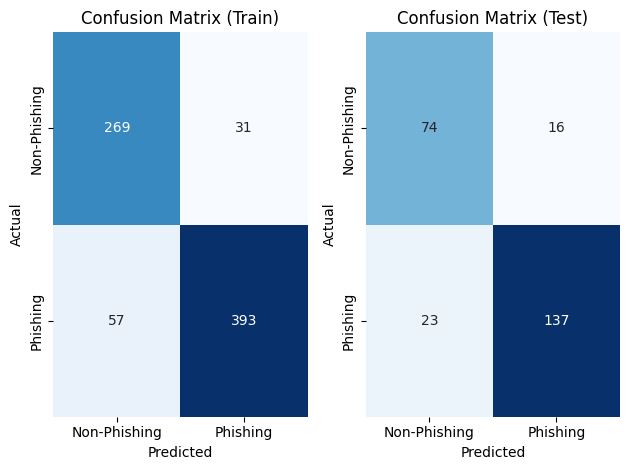

Accuracy (Train): 0.8827, TPR (Train): 0.8733, FPR (Train): 0.1033
Accuracy (Test): 0.8440, TPR (Test): 0.8562, FPR (Test): 0.1778


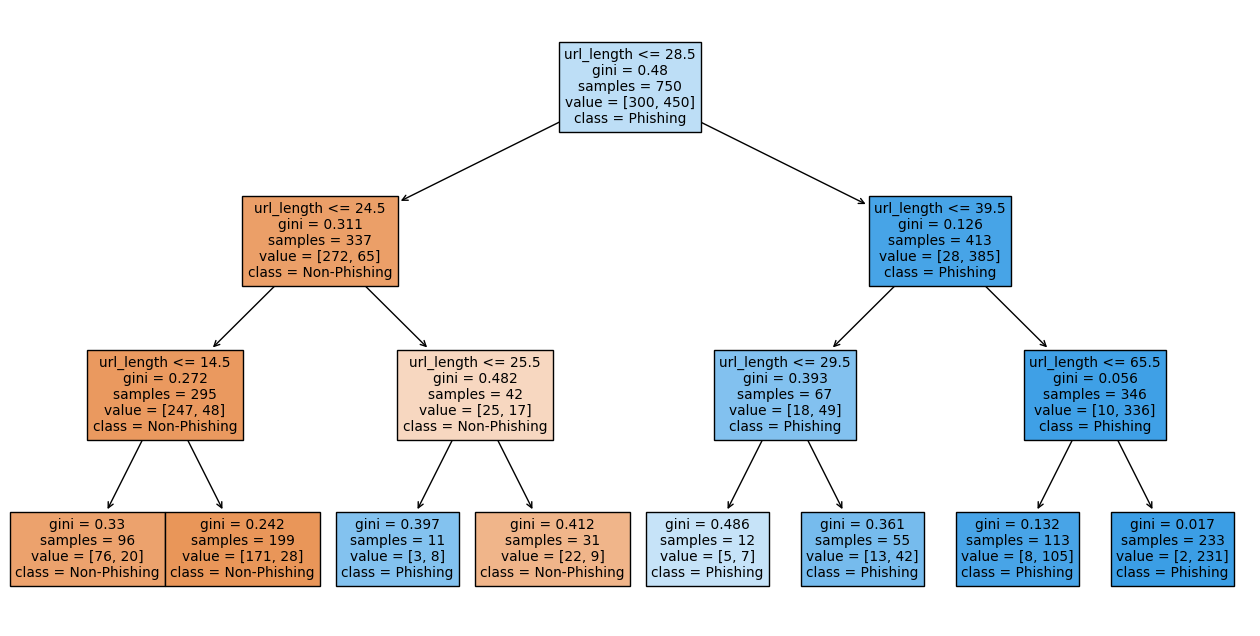

In [99]:
# Modeling using a Decision Tree

X = url_information[['length_url']]
y = url_information['phishing']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

decision_tree = DecisionTreeClassifier(max_depth=3, random_state=69)
decision_tree.fit(X_train, y_train)
evaluate_model(decision_tree, X_train, y_train, X_test, y_test)

plt.figure(figsize=(16,8))
plot_tree(decision_tree, filled=True, feature_names=['url_length'], class_names=['Non-Phishing', 'Phishing'])
plt.show()